In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle 
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import requests

In [ ]:
import json

In [ ]:
data_dict = requests.get('https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json').json()

In [ ]:
print("Nombres d'article:",len(data_dict))
print("Avec ces informations pour chacun:")
for i in data_dict:
    for cle, val in i.items():
        print(cle)
    break

Nombres d'article: 682
Avec ces informations pour chacun:
id
slug
title
has_other_authors
impact_factor
goals_plain
verbose_date
authors
document_link
specialties
category
journal
link
results
synthesis
strength_of_evidence_details
goals
methods
pubmed_id
doi
abstract
topics
author_list
publication_date


In [ ]:
print(data_dict[61])

{'id': 660, 'slug': 'kawasaki-like-multisystem-inflammatory-syndrome-in-children-during-the-covid-19-', 'title': 'Kawasaki-like multisystem inflammatory syndrome in children during the covid-19 pandemic in Paris, France: prospective observational study', 'has_other_authors': True, 'impact_factor': {'id': 2, 'name': 'Faible', 'posts_count': 505, 'color': 'red', 'order': 3}, 'goals_plain': "Décrire les caractéristiques démographiques et cliniques d'enfants affectés par un syndrome inflammatoire multisystémique proche de la maladie de Kawasaki et évaluer son association temporelle avec une potentielle infection par le SARS-CoV-2.", 'verbose_date': '05.06.2020', 'authors': 'Toubiana J', 'document_link': 'https://www.bmj.com/content/bmj/369/bmj.m2094.full.pdf', 'specialties': [{'id': 4, 'name': 'Anesthésie-Réanimation'}, {'id': 12, 'name': 'Infectiologie'}, {'id': 9, 'name': 'Pédiatrie'}], 'category': {'id': 5, 'name': 'Epidémiologique', 'icon': 'icon-virus'}, 'journal': {'id': 57, 'name': 

In [ ]:
print(data_dict[61]['category'])

{'id': 5, 'name': 'Epidémiologique', 'icon': 'icon-virus'}


In [ ]:
Labels = []
for a in data_dict: 
  b = a['category']
  if b['name'] not in Labels :
    Labels.append(b['name'])

In [ ]:
Labels

['Pronostique',
 'Modélisation',
 'Thérapeutique',
 'Autres',
 'Epidémiologique',
 'Diagnostique',
 'Recommandations']

In [ ]:
categories = {} # nombres d'articles par categorie 
for i in range(len(Labels)):
  categories[Labels[i]]=0
for article in data_dict:
    categories[article['category']['name']]+=1
      

In [ ]:
categories

{'Autres': 93,
 'Diagnostique': 76,
 'Epidémiologique': 230,
 'Modélisation': 41,
 'Pronostique': 84,
 'Recommandations': 11,
 'Thérapeutique': 147}

Text(0.5, 1.0, 'Nombre des articles par catégorie')

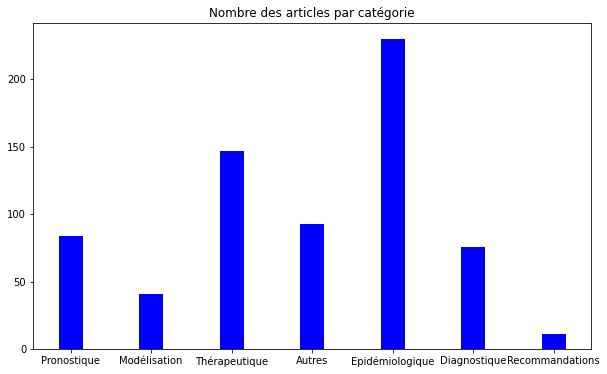

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(categories.keys(), categories.values(), width=0.3, color='b')
plt.title('Nombre des articles par catégorie' )

#Les classes ne sont pas équilibrées

In [ ]:
title =[]
abstract=[]
y =[]
yabs =[]
for article in data_dict:
  title.append(article['title'])
  y.append(article['category']['name'])
  if 'abstract' in article.keys():
    abstract.append(article['abstract'])
    yabs.append(article['category']['name'])
  else :
    pass
  

In [ ]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
title[0]

'Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study'

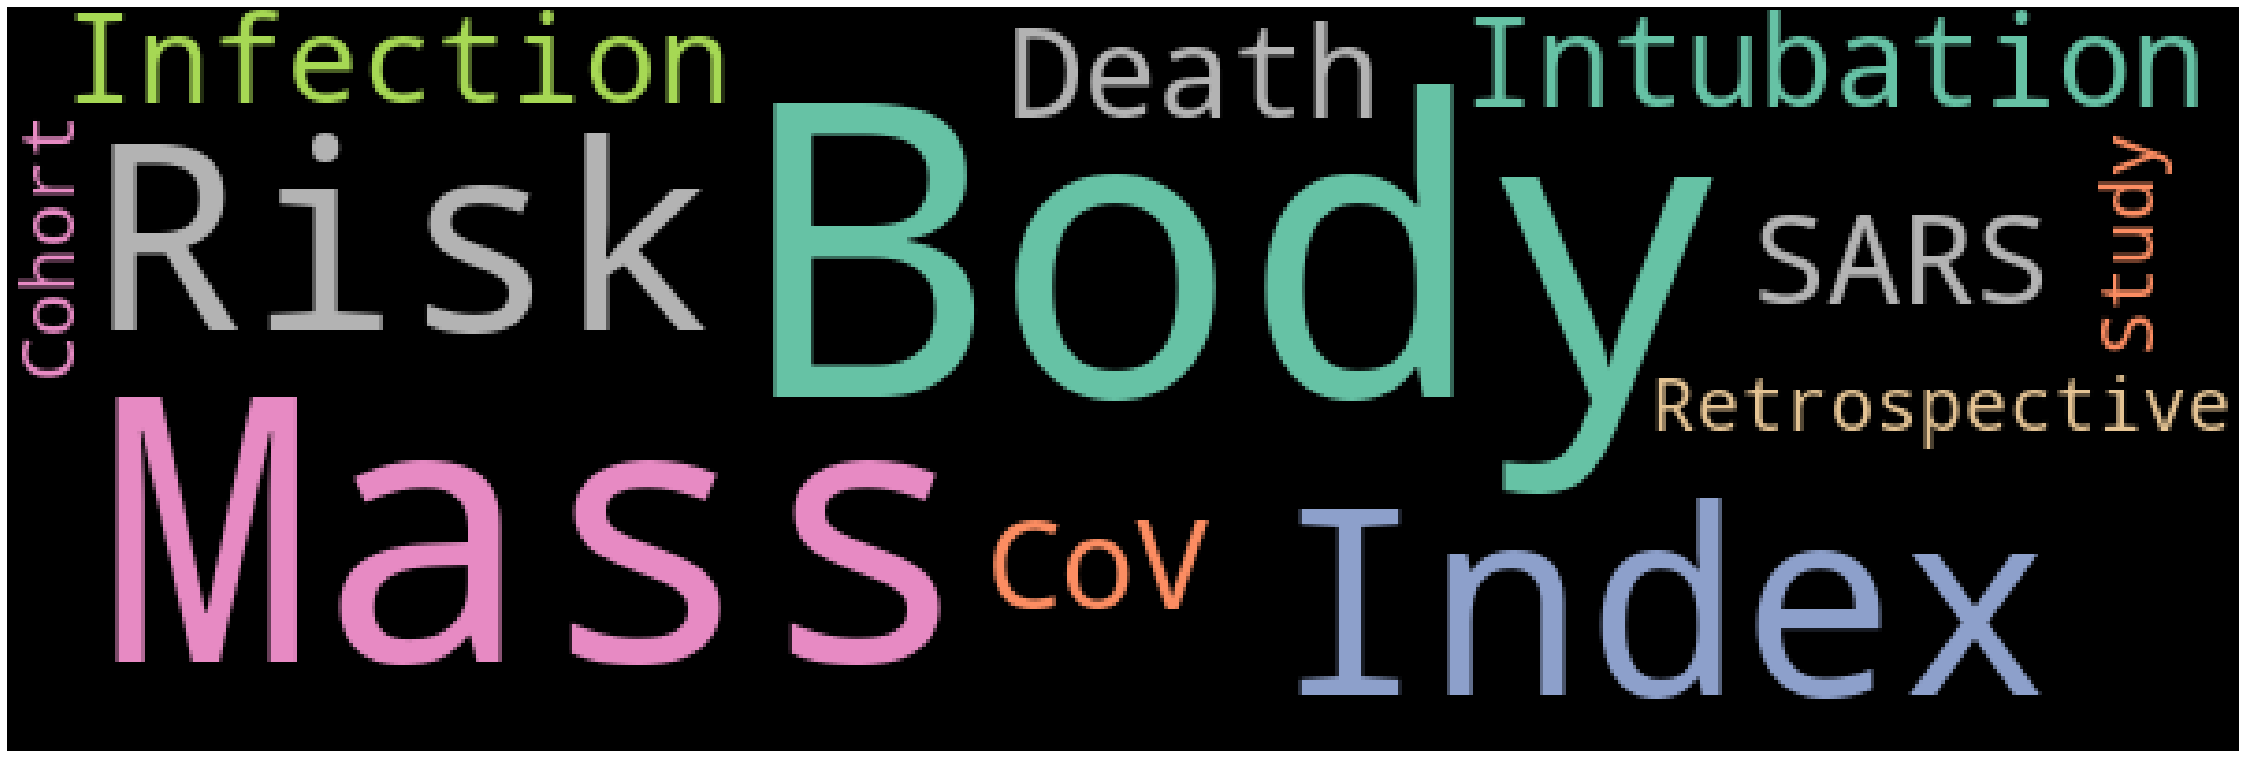

In [ ]:
wordcloud = WordCloud(width = 600, height = 200, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(title[0])
  # Plot
plot_cloud(wordcloud)

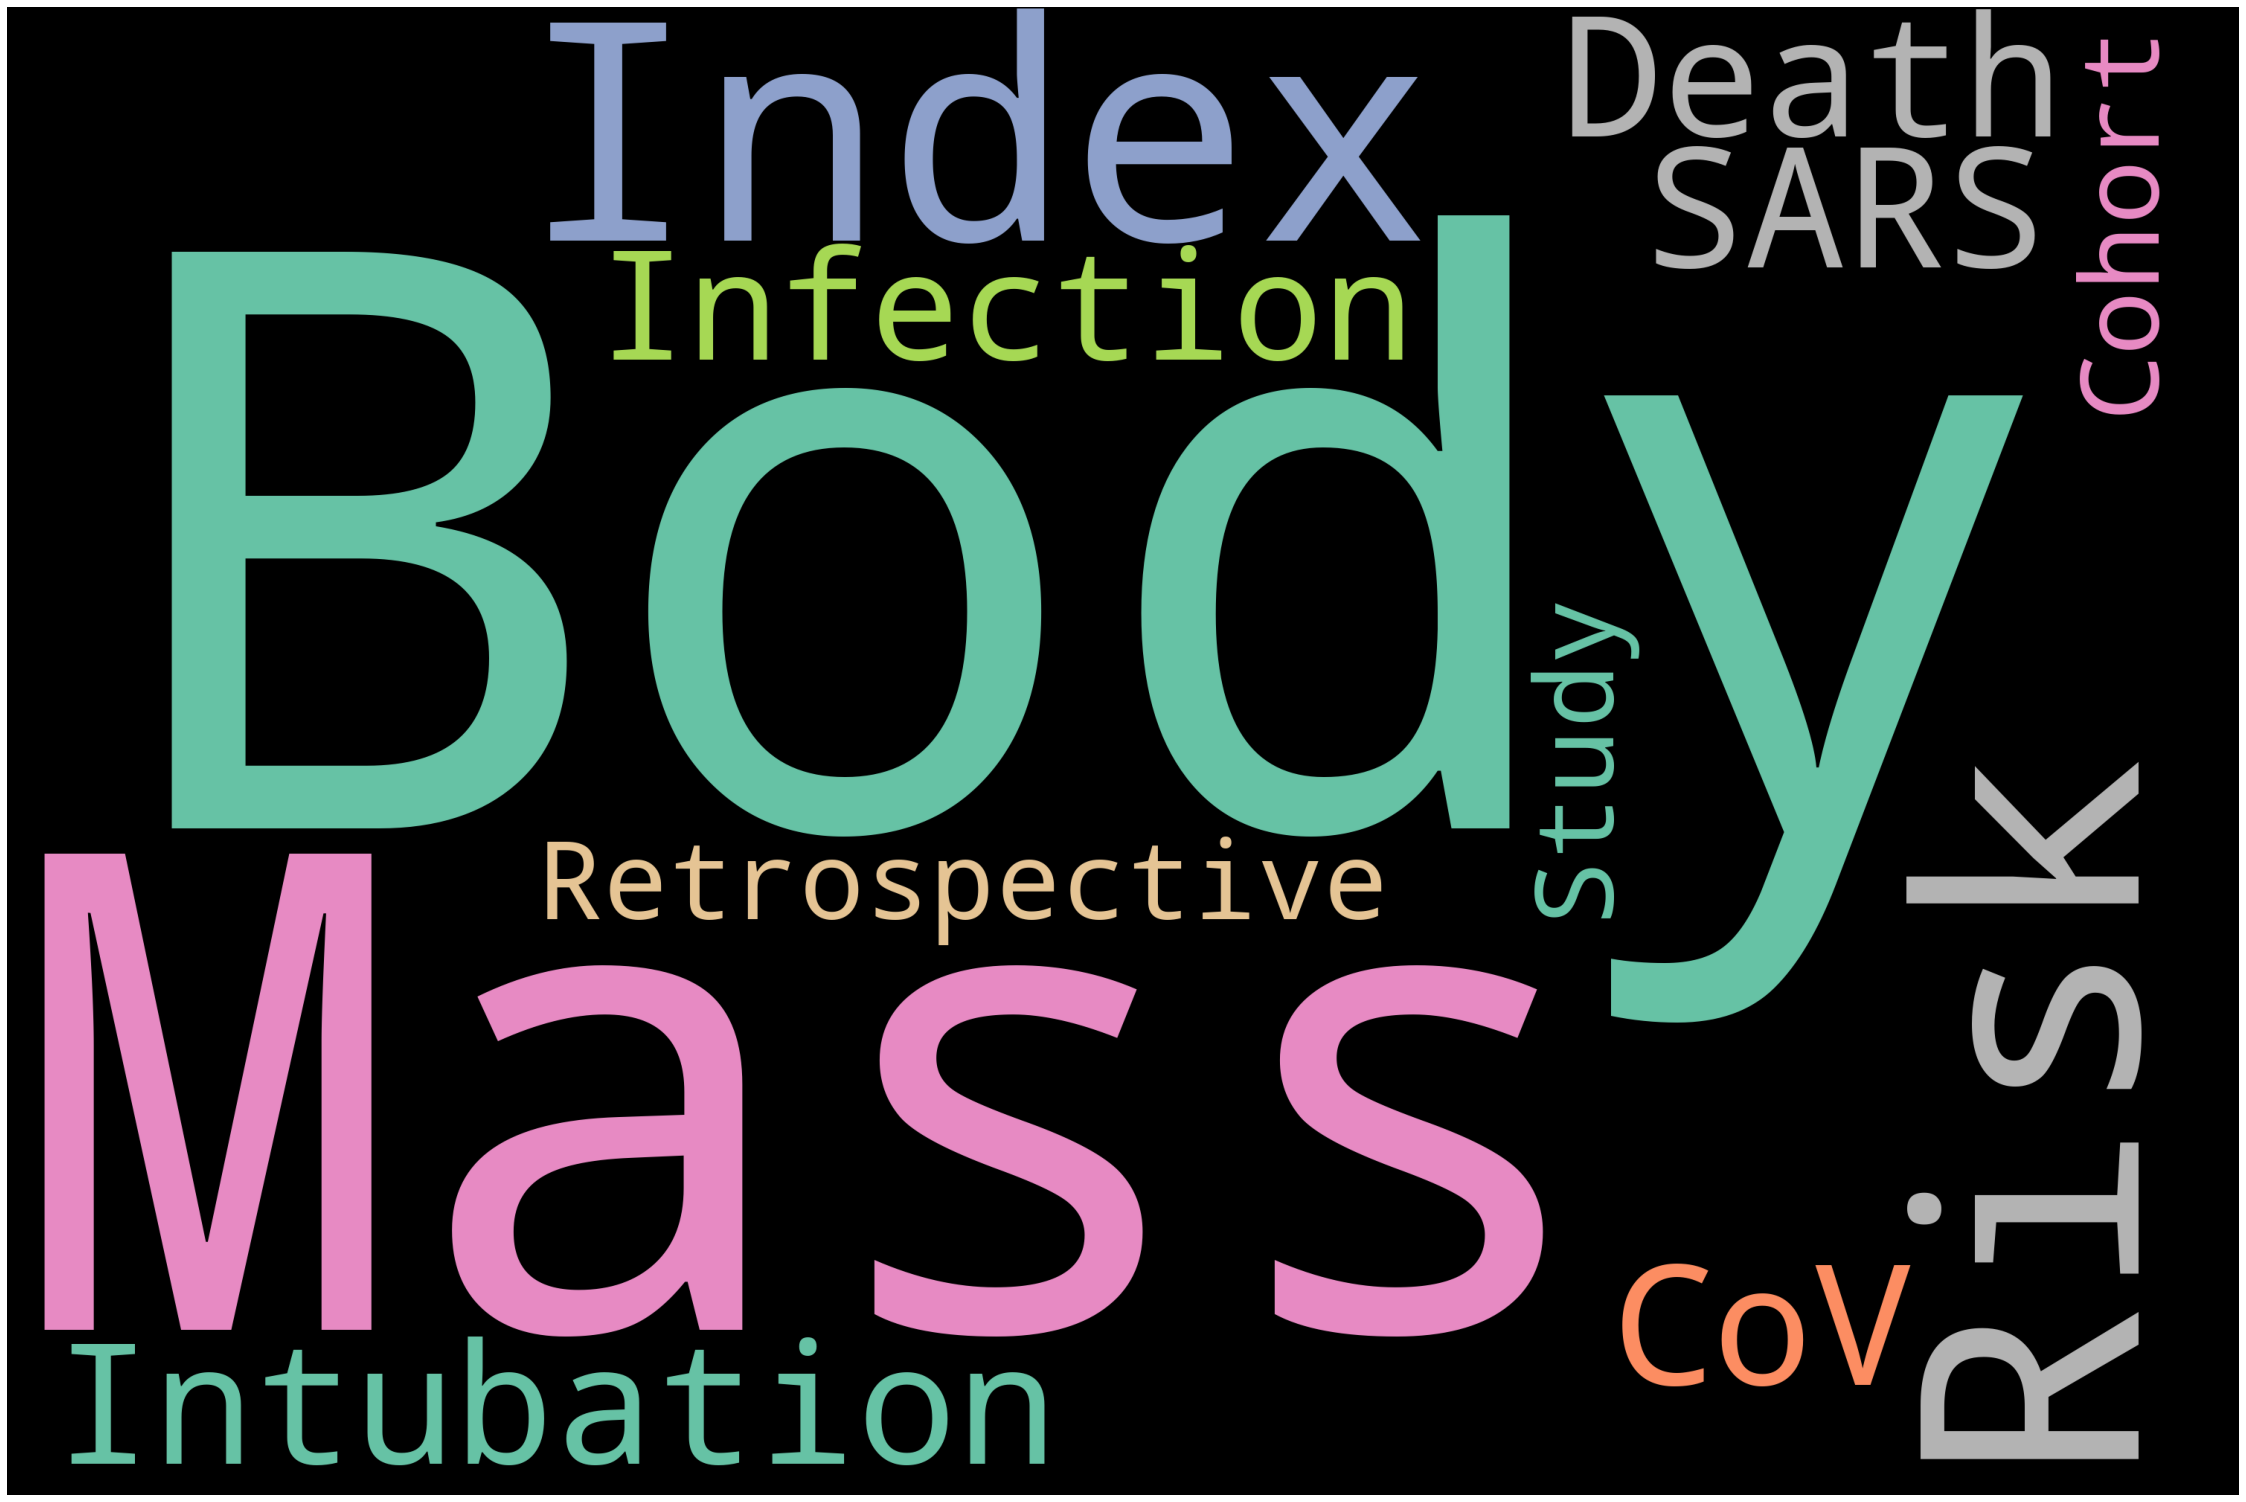

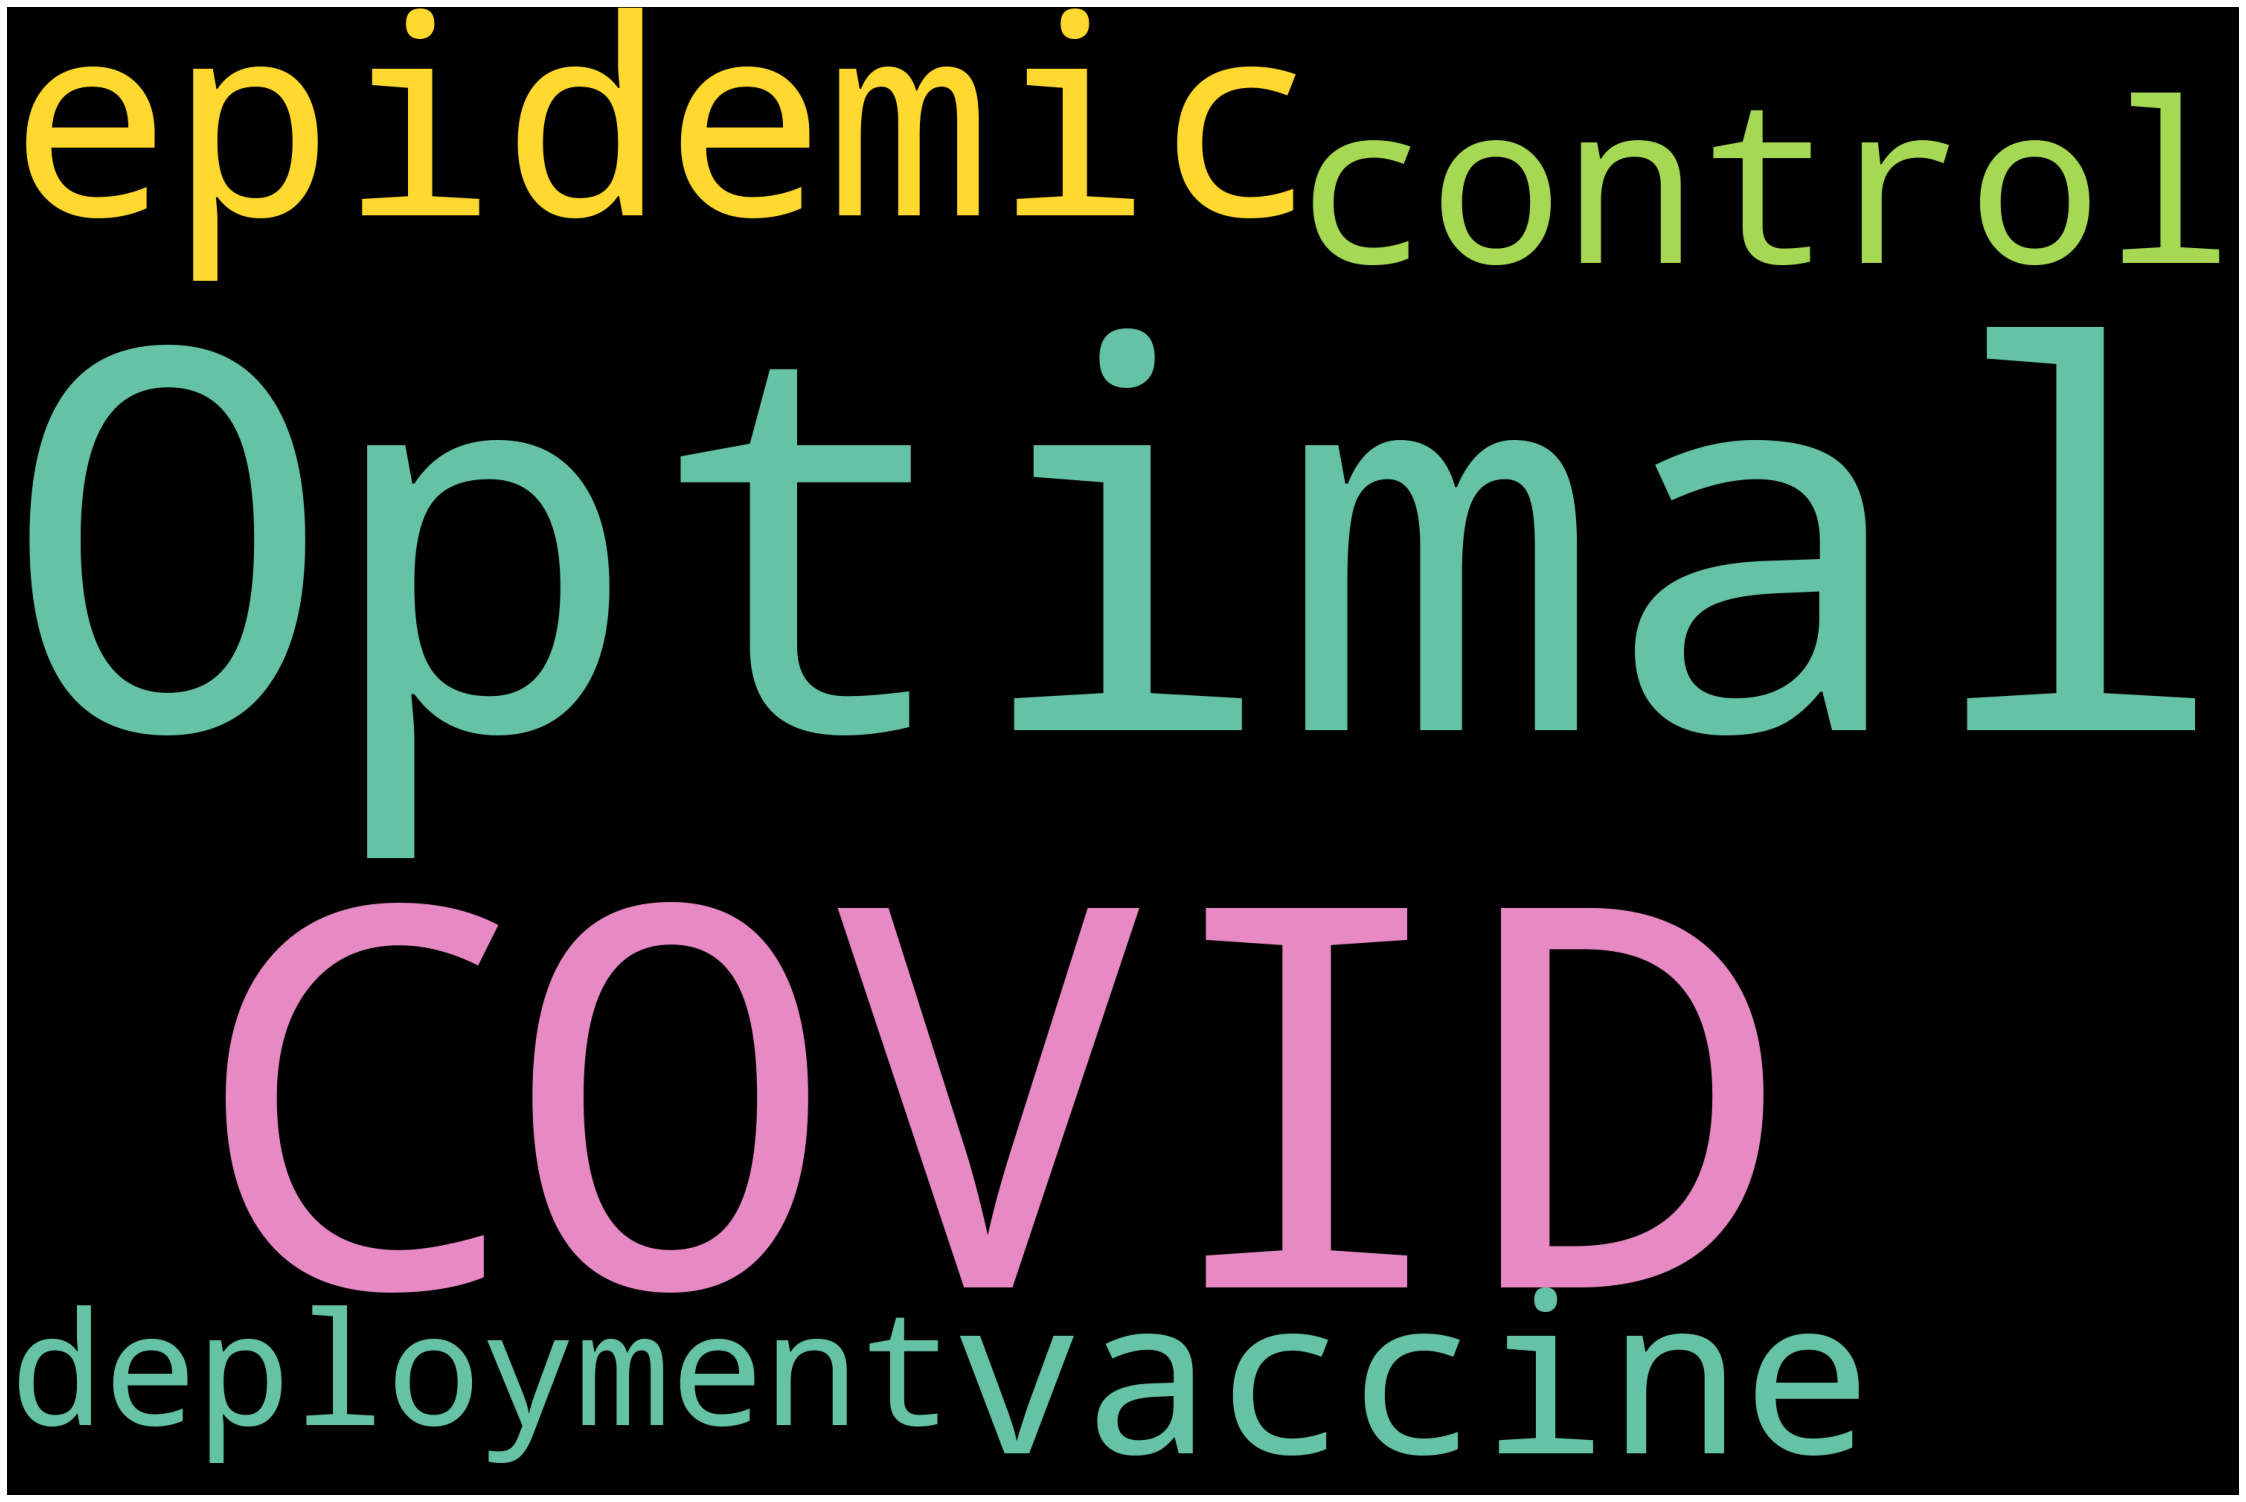

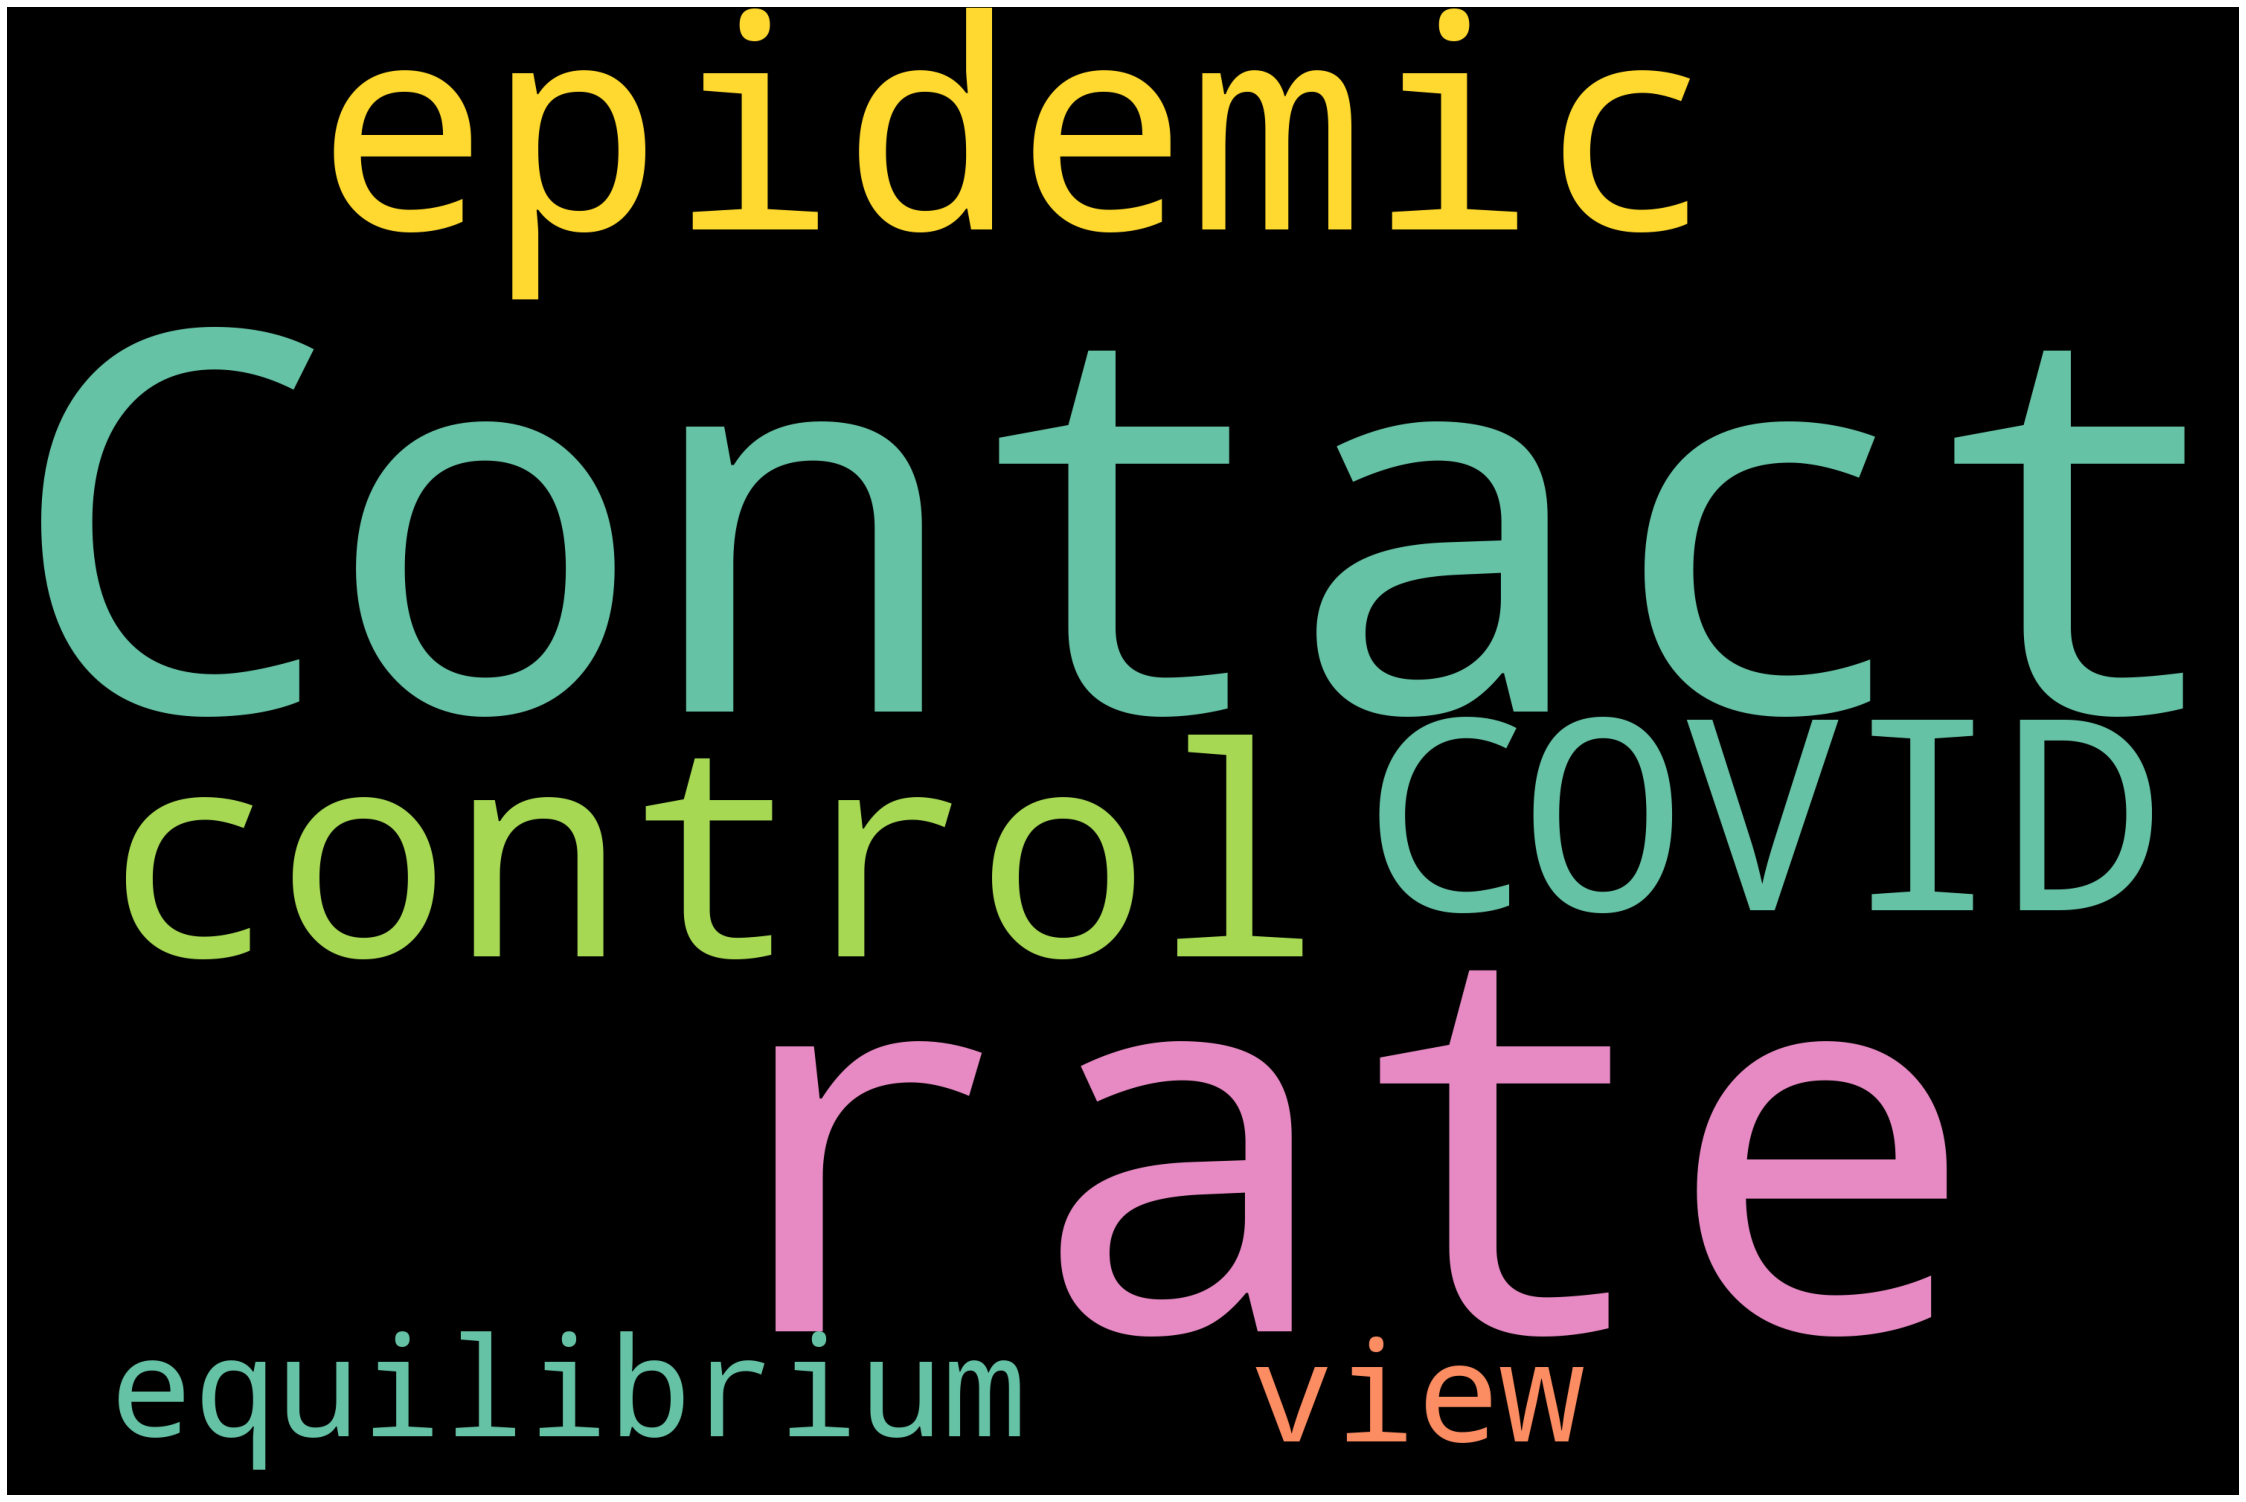

In [ ]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
i=1
for text in title[:3] : 
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  # Plot
  plot_cloud(wordcloud)
  wordcloud.to_file("wordcloud_title"+str(i)+".png")
  i+=1

#title preprocessing

In [ ]:
title[0]

'Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study'

In [ ]:
import string
import re
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
for i in range (len(title)) :
  title[i] = REPLACE_BY_SPACE_RE.sub(' ', title[i])
  title[i] = title[i].lower()
  title[i]= title[i].translate( str.maketrans('', '', string.punctuation))


In [ ]:
title[0]

'body mass index and risk for intubation or death in sarscov2 infection a retrospective cohort study'

#Adaboost + tfidf

#TFIDF
![original image](https://cdn.mathpix.com/snip/images/JbthPii7H4wstHdaGozJJQr5RZYCOX64lv_h9NlI4rc.original.fullsize.png)

In [ ]:
tf = TfidfVectorizer(stop_words="english", max_features=1000)
tf.fit(title)
X1 = tf.transform(title)

In [ ]:
X1

<682x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 5688 stored elements in Compressed Sparse Row format>

In [ ]:
Y = np.array(y)
le = LabelEncoder()
Y = le.fit_transform(Y) 
print(np.shape(Y))

(682,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2)

In [ ]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = OneVsRestClassifier(AdaBoostClassifier(random_state=1, n_estimators= 200))
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=200,
                                                 random_state=1),
                    n_jobs=None)

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred,target_names=Labels))

                 precision    recall  f1-score   support

    Pronostique       0.29      0.23      0.26        22
   Modélisation       0.67      0.43      0.52        14
  Thérapeutique       0.60      0.55      0.58        47
         Autres       0.50      0.60      0.55         5
Epidémiologique       0.29      0.27      0.28        15
   Diagnostique       0.00      0.00      0.00         4
Recommandations       0.78      0.70      0.74        30

      micro avg       0.56      0.47      0.51       137
      macro avg       0.45      0.40      0.42       137
   weighted avg       0.54      0.47      0.50       137
    samples avg       0.43      0.47      0.44       137



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#RandomForest + tfidf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf1 = OneVsRestClassifier(RandomForestClassifier(max_depth=10, random_state=0))
clf1.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                              

In [ ]:
y_pred1 = clf1.predict(X_test)

print(classification_report(y_test, y_pred1,target_names=Labels))

                 precision    recall  f1-score   support

    Pronostique       1.00      0.05      0.09        22
   Modélisation       0.00      0.00      0.00        14
  Thérapeutique       1.00      0.19      0.32        47
         Autres       0.00      0.00      0.00         5
Epidémiologique       0.00      0.00      0.00        15
   Diagnostique       0.00      0.00      0.00         4
Recommandations       1.00      0.20      0.33        30

      micro avg       1.00      0.12      0.21       137
      macro avg       0.43      0.06      0.11       137
   weighted avg       0.72      0.12      0.20       137
    samples avg       0.12      0.12      0.12       137



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Abstract

In [ ]:
j = []
a = abstract
for i in range (len(a)):
  if type(a[i])!=str:
    j.append(i)

In [ ]:
for index in sorted(j, reverse=True):
    del abstract[index]
    del yabs[index]

In [ ]:
abstract[0]

'Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.\nTo determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).\nRetrospective cohort study.\nA quaternary academic medical center and community hospital in New York City.\n2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.\nBody mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.\nOver a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitalized. Compared wi

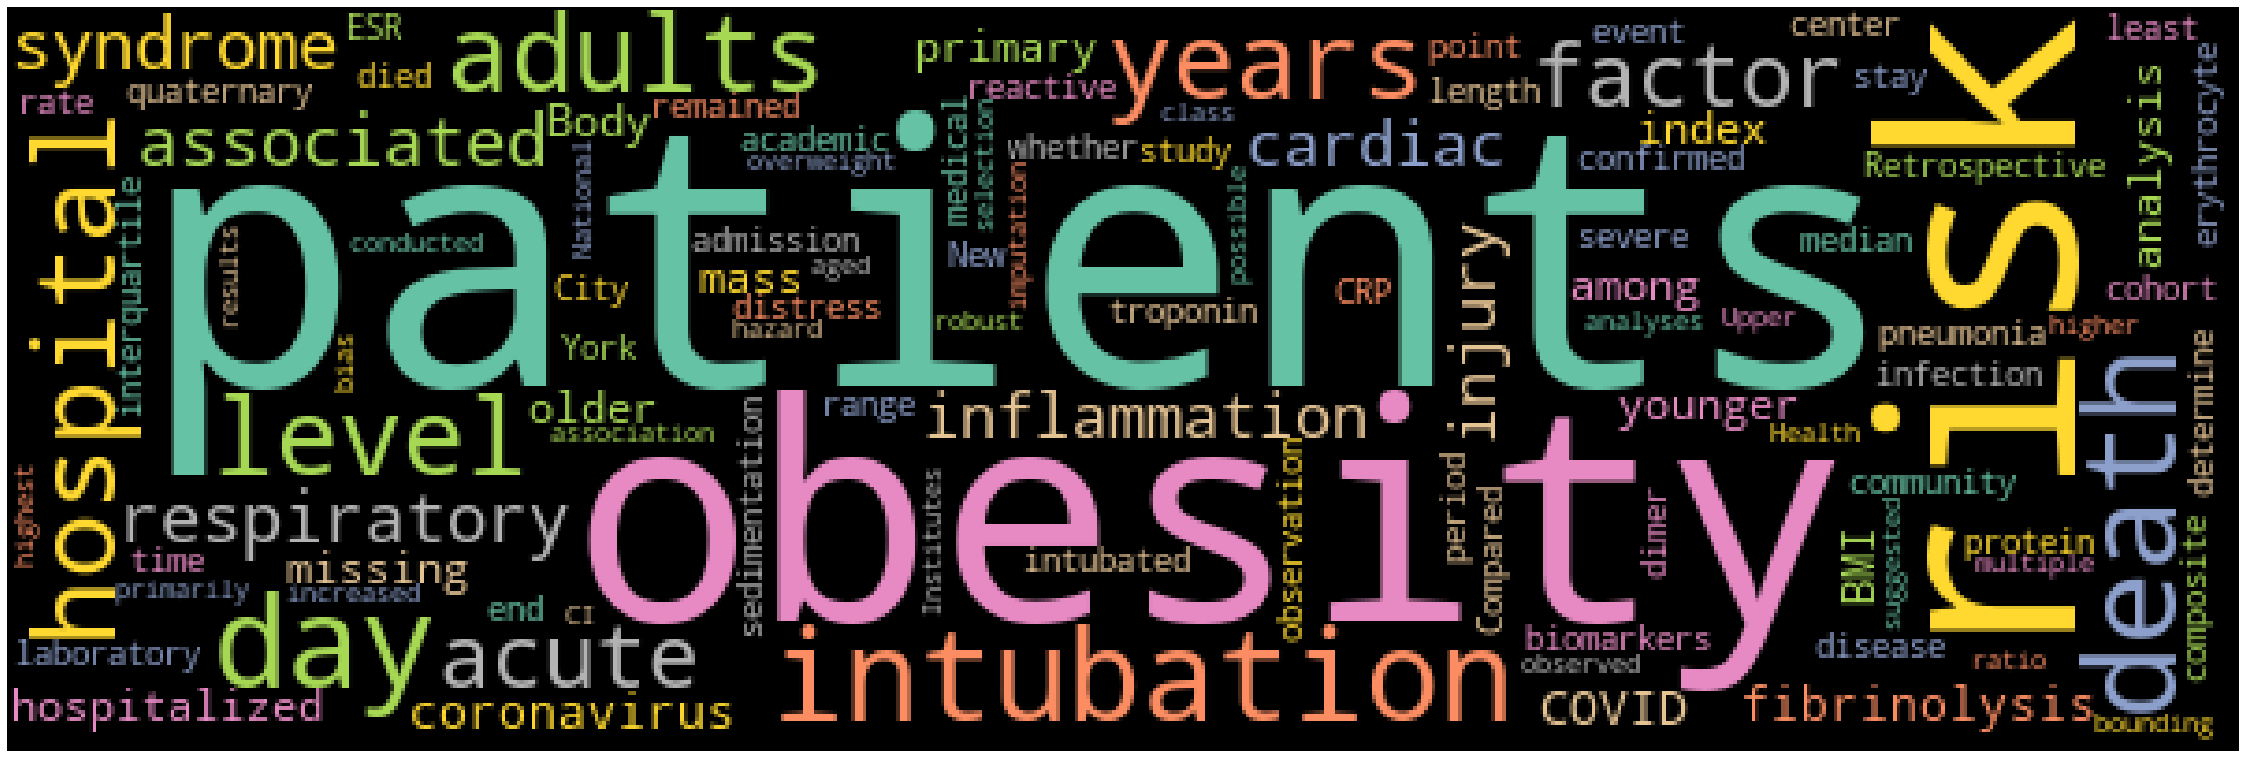

In [ ]:
wordcloud = WordCloud(width = 600, height = 200, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(abstract[0])
  # Plot
plot_cloud(wordcloud)

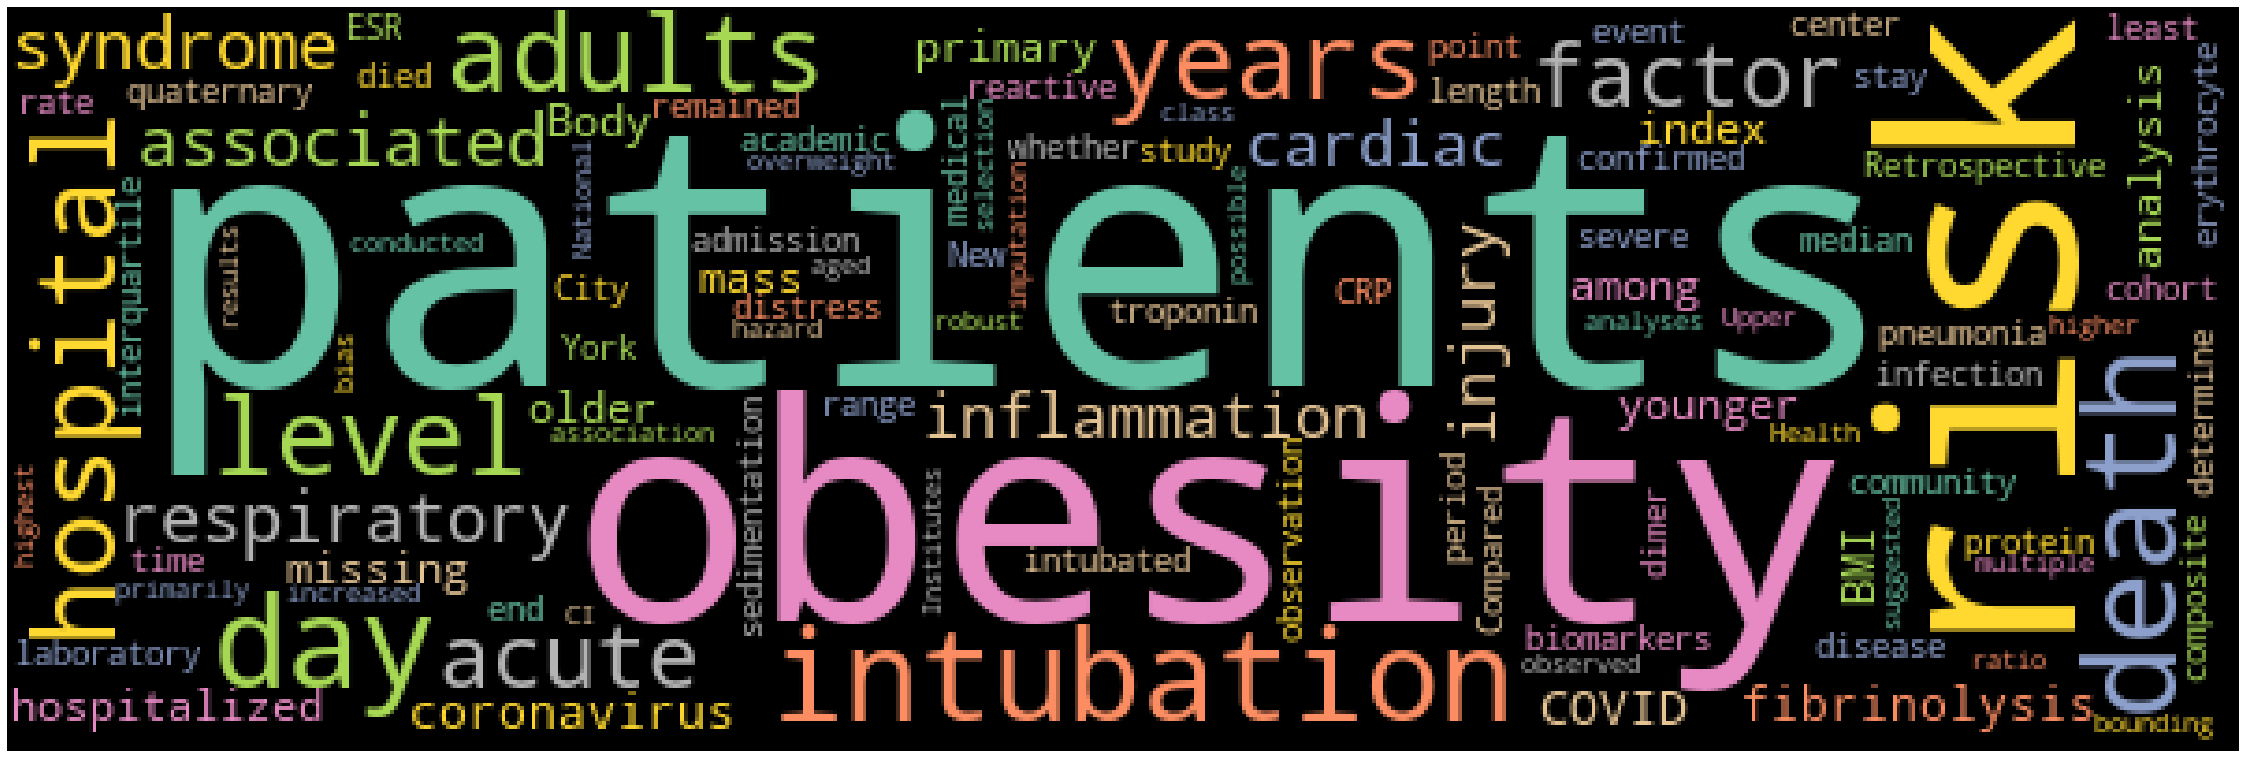

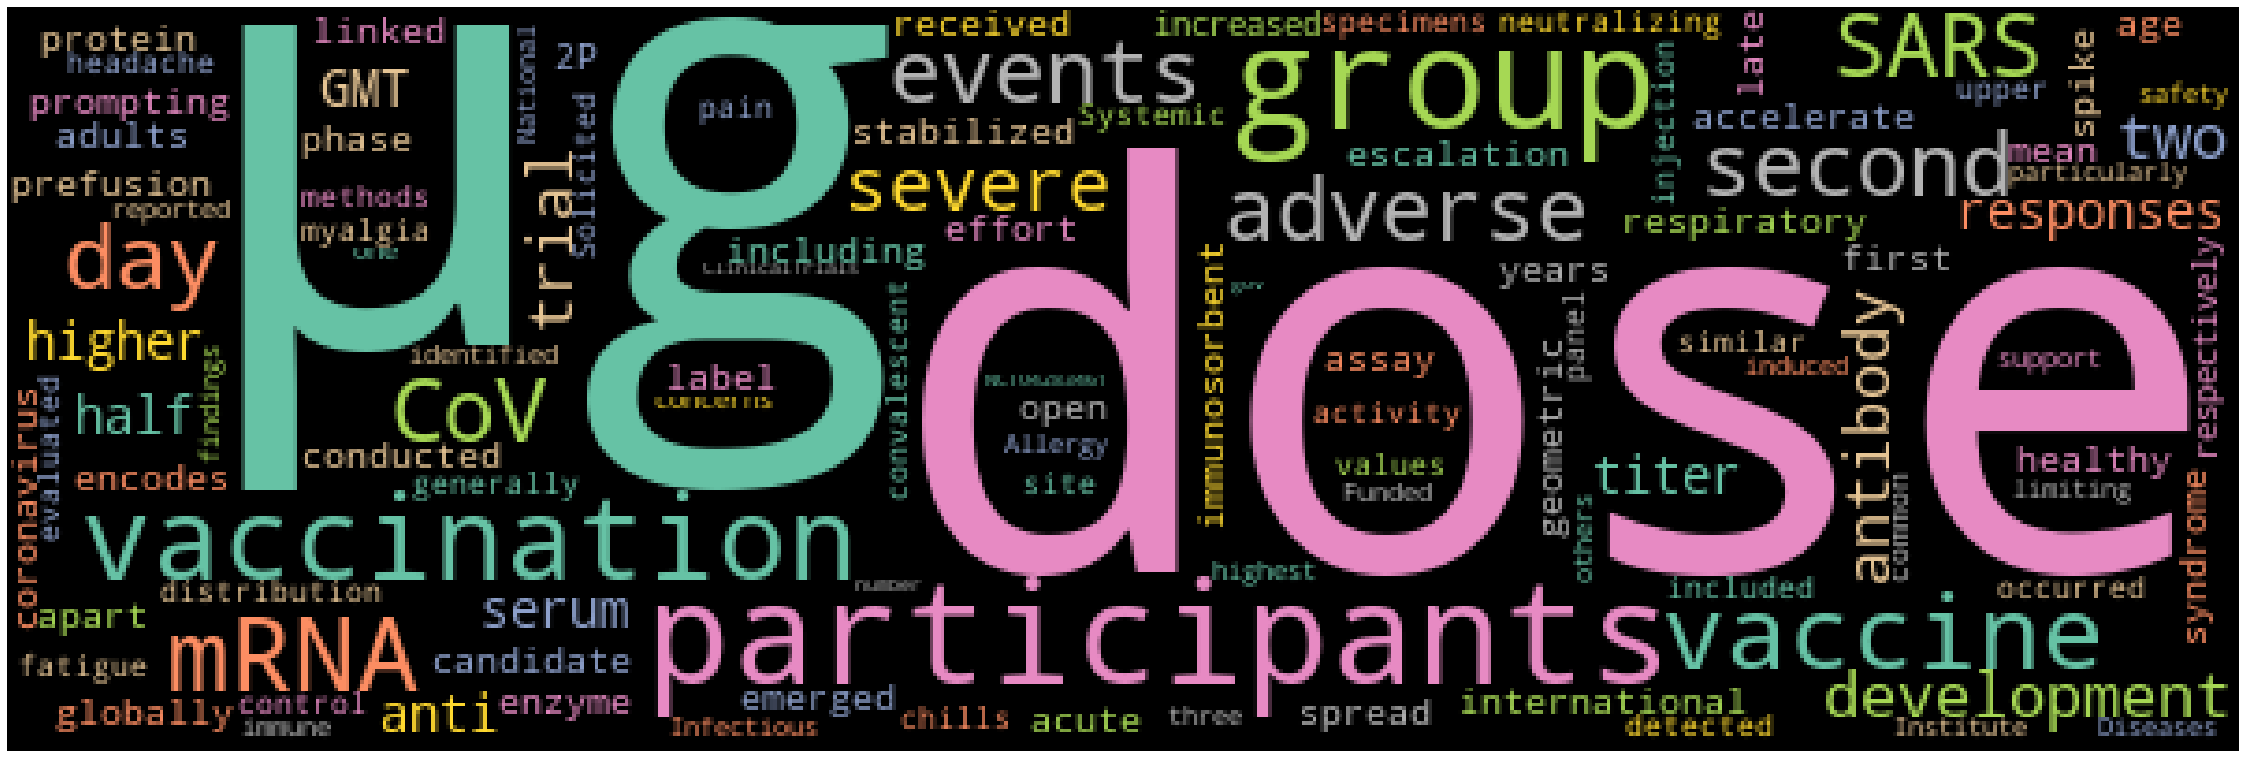

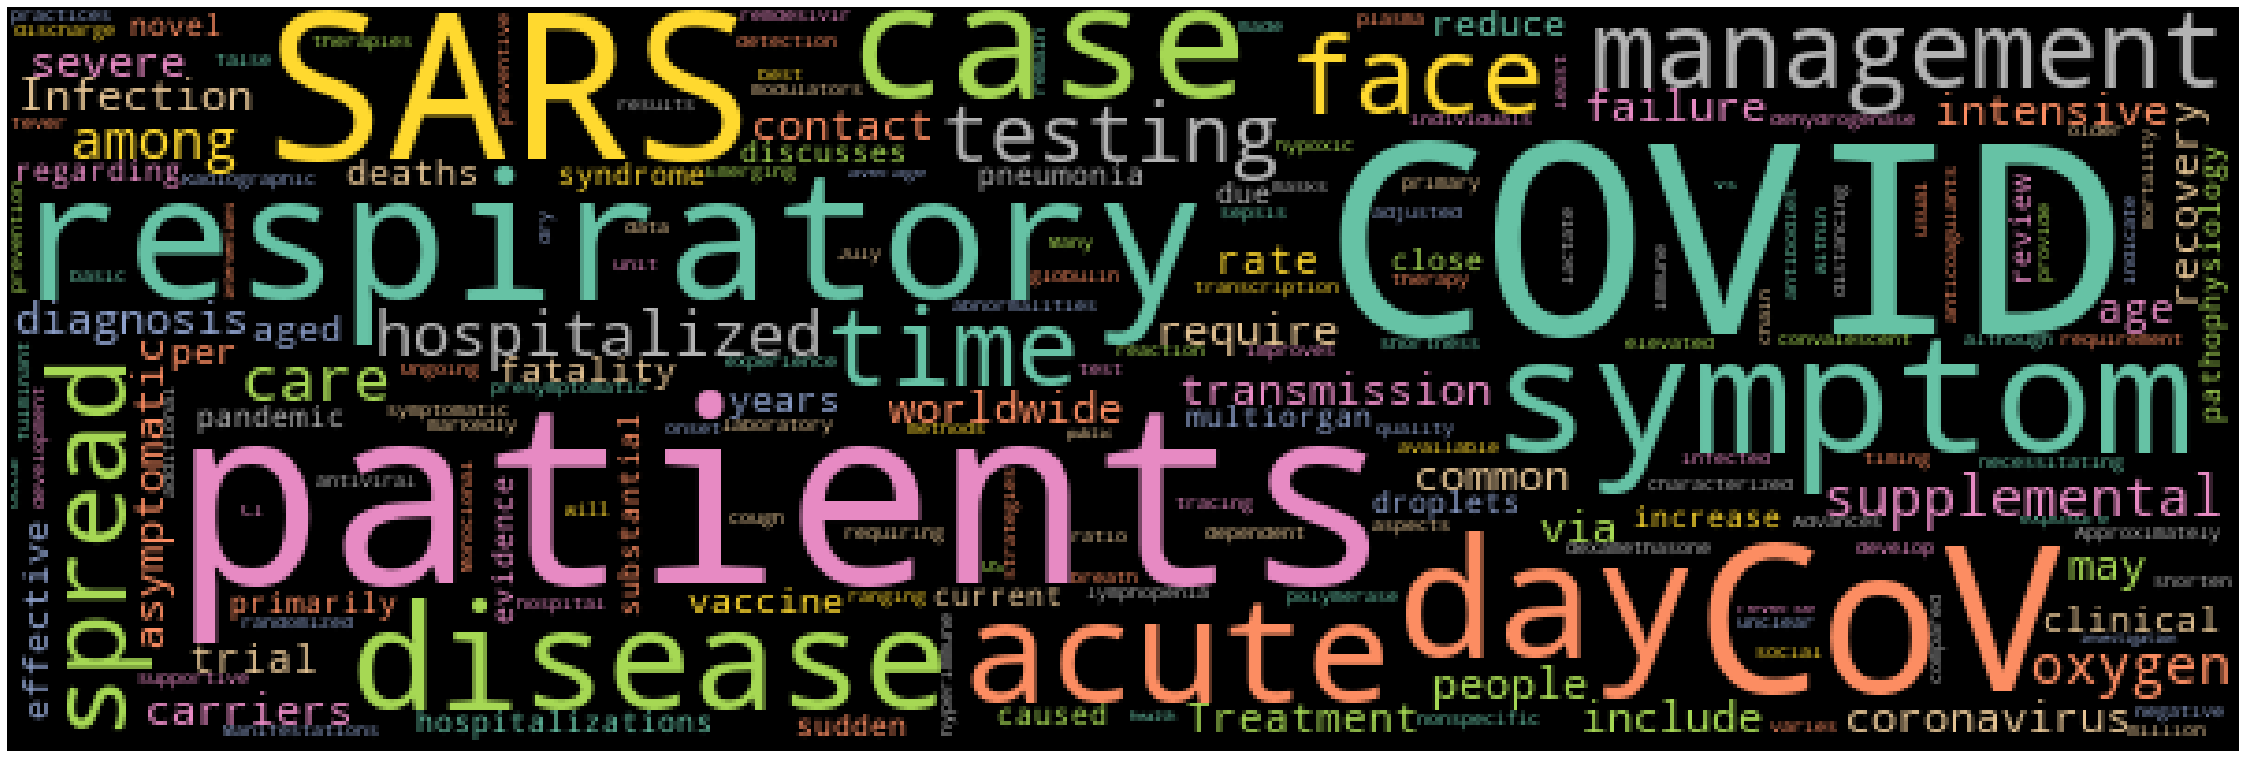

In [ ]:
i=1
for text in abstract[:3] : 
  wordcloud = WordCloud(width = 600, height = 200, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  # Plot
  plot_cloud(wordcloud)
  wordcloud.to_file("wordcloud_abstract"+str(i)+".png")
  i+=1

#abstract preprocessing 

In [ ]:
abstract[0]

'Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.\nTo determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).\nRetrospective cohort study.\nA quaternary academic medical center and community hospital in New York City.\n2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.\nBody mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.\nOver a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitalized. Compared wi

In [ ]:
import re
import string
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
for i in range (len(abstract)) :
  abstract[i] = REPLACE_BY_SPACE_RE.sub(' ', abstract[i])
  abstract[i] = abstract[i].lower()
  abstract[i]= abstract[i].translate( str.maketrans('', '', string.punctuation))



In [ ]:
abstract[0]

'obesity is a risk factor for pneumonia and acute respiratory distress syndrome\nto determine whether obesity is associated with intubation or death  inflammation  cardiac injury  or fibrinolysis in coronavirus disease 2019  covid19 \nretrospective cohort study\na quaternary academic medical center and community hospital in new york city\n2466 adults hospitalized with laboratoryconfirmed severe acute respiratory syndrome coronavirus 2 infection over a 45day period with at least 47 days of inhospital observation\nbody mass index  bmi   admission biomarkers of inflammation  creactive protein  crp  level and erythrocyte sedimentation rate  esr    cardiac injury  troponin level   and fibrinolysis  ddimer level  the primary end point was a composite of intubation or death in timetoevent analysis\nover a median hospital length of stay of 7 days  interquartile range  3 to 14 days   533 patients  22  were intubated  627  25  died  and 59  2  remained hospitalized compared with overweight patie

In [ ]:
Yabs = np.array(yabs)
le = LabelEncoder()
Yabs = le.fit_transform(Yabs) 
print(np.shape(Yabs))


(377,)


#TFIDF

In [ ]:
tf = TfidfVectorizer(stop_words="english", max_features=1000)
tf.fit(abstract)
X2 = tf.transform(abstract)

In [ ]:
from sklearn.model_selection import train_test_split
Xabs_train, Xabs_test, yabs_train, yabs_test = train_test_split(X2, Yabs, test_size=0.2)

In [ ]:
# Converts the labels to a one-hot representation
yabs_train = keras.utils.to_categorical(yabs_train, num_classes)
yabs_test = keras.utils.to_categorical(yabs_test, num_classes)

#Adaboost+tfidf

In [ ]:
clfa = OneVsRestClassifier(AdaBoostClassifier(random_state=1, n_estimators= 200))
clfa.fit(Xabs_train, yabs_train)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=200,
                                                 random_state=1),
                    n_jobs=None)

In [ ]:
y_pred = clfa.predict(Xabs_test)

print(classification_report(yabs_test, y_pred,target_names=Labels))

                 precision    recall  f1-score   support

    Pronostique       0.20      0.33      0.25         6
   Modélisation       0.60      0.38      0.46         8
  Thérapeutique       0.44      0.46      0.45        26
         Autres       0.00      0.00      0.00         4
Epidémiologique       0.33      0.06      0.10        17
   Diagnostique       0.00      0.00      0.00         2
Recommandations       0.50      0.38      0.43        13

      micro avg       0.41      0.30      0.35        76
      macro avg       0.30      0.23      0.24        76
   weighted avg       0.39      0.30      0.32        76
    samples avg       0.26      0.30      0.27        76



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Randomforest + tfidf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfr = OneVsRestClassifier(RandomForestClassifier(max_depth=10, random_state=0))
clfr.fit(Xabs_train, yabs_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                              

In [ ]:
y_predr = clfr.predict(Xabs_test)

print(classification_report(yabs_test, y_predr,target_names=Labels))

                 precision    recall  f1-score   support

    Pronostique       0.00      0.00      0.00         6
   Modélisation       1.00      0.25      0.40         8
  Thérapeutique       0.77      0.38      0.51        26
         Autres       0.00      0.00      0.00         4
Epidémiologique       0.00      0.00      0.00        17
   Diagnostique       0.00      0.00      0.00         2
Recommandations       1.00      0.23      0.38        13

      micro avg       0.83      0.20      0.32        76
      macro avg       0.40      0.12      0.18        76
   weighted avg       0.54      0.20      0.28        76
    samples avg       0.20      0.20      0.20        76



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


L'impact de deséquilibre sur le nombre d'exemple par classe est donnée par le F1 score

#Model deep

#tokenizer

In [ ]:
import itertools
import os
import keras
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix , f1_score

from tensorflow import keras
layers = keras.layers
models = keras.models

In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [ ]:
from sklearn.model_selection import train_test_split
Y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(title, Y, test_size=0.2)

In [ ]:
tokenize.fit_on_texts(X_train) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(X_train, mode='tfidf') 
x_test = tokenize.texts_to_matrix(X_test, mode='tfidf')

In [ ]:
tokenize.word_index

{'of': 1,
 'the': 2,
 'and': 3,
 'in': 4,
 'with': 5,
 'to': 6,
 'covid19': 7,
 'patients': 8,
 'a': 9,
 'for': 10,
 'were': 11,
 'was': 12,
 'disease': 13,
 'sarscov2': 14,
 'coronavirus': 15,
 'or': 16,
 'on': 17,
 'severe': 18,
 'is': 19,
 'from': 20,
 'we': 21,
 'clinical': 22,
 'that': 23,
 'as': 24,
 'infection': 25,
 'by': 26,
 'respiratory': 27,
 'study': 28,
 '2019': 29,
 'this': 30,
 'an': 31,
 'be': 32,
 'cases': 33,
 'acute': 34,
 'risk': 35,
 'at': 36,
 '2020': 37,
 'are': 38,
 'data': 39,
 'syndrome': 40,
 'symptoms': 41,
 '95': 42,
 'had': 43,
 '2': 44,
 'ci': 45,
 'health': 46,
 'during': 47,
 'mortality': 48,
 'who': 49,
 'days': 50,
 'associated': 51,
 'than': 52,
 'treatment': 53,
 'between': 54,
 'china': 55,
 'studies': 56,
 'years': 57,
 'care': 58,
 'have': 59,
 'these': 60,
 'may': 61,
 'hospital': 62,
 'more': 63,
 'after': 64,
 'has': 65,
 'not': 66,
 'age': 67,
 'group': 68,
 'among': 69,
 'pandemic': 70,
 'positive': 71,
 'higher': 72,
 'all': 73,
 'pneumoni

In [ ]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(y_train)
y1_train = encoder.transform(y_train)
y1_test = encoder.transform(y_test)

In [ ]:
# Converts the labels to a one-hot representation
num_classes = np.max(y1_train) + 1
y_train = keras.utils.to_categorical(y1_train, num_classes)
y_test = keras.utils.to_categorical(y1_test, num_classes)

In [ ]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (545, 1000)
x_test shape: (137, 1000)
y_train shape: (545, 7)
y_test shape: (137, 7)


In [ ]:
batch_size = 32
epochs = 20
drop_ratio = 0.5

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
16/16 [==============================] - 1s 17ms/step - loss: 1.8809 - categorical_accuracy: 0.2038 - val_loss: 1.5779 - val_categorical_accuracy: 0.4545
Epoch 2/20
16/16 [==============================] - 0s 7ms/step - loss: 1.3282 - categorical_accuracy: 0.4940 - val_loss: 1.4294 - val_categorical_accuracy: 0.5091
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 0.9781 - categorical_accuracy: 0.7221 - val_loss: 1.3227 - val_categorical_accuracy: 0.5818
Epoch 4/20
16/16 [==============================] - 0s 8ms/step - loss: 0.7533 - categorical_accuracy: 0.8291 - val_loss: 1.2550 - val_categorical_accuracy: 0.5818
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 0.5328 - categorical_accuracy: 0.9077 - val_loss: 1.2112 - val_categorical_accuracy: 0.6000
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 0.4299 - categorical_accuracy: 0.9446 - val_loss: 1.1943 - val_categorical_accuracy: 0.6000
Epoch 7/20
16/1

In [ ]:
# Evaluate the accuracy of our trained model_categorical accuracy
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 3ms/step - loss: 1.2728 - categorical_accuracy: 0.6131
Test loss: 1.272803544998169
Test accuracy: 0.6131386756896973


In [ ]:
yhat_classes = model.predict_classes(x_test, verbose=0)
yhat_classes
print(classification_report(yhat_classes, y1_test,target_names=Labels))

                 precision    recall  f1-score   support

    Pronostique       0.29      0.58      0.39        12
   Modélisation       0.55      0.67      0.60         9
  Thérapeutique       0.80      0.56      0.66        66
         Autres       0.70      0.78      0.74         9
Epidémiologique       0.35      0.43      0.39        14
   Diagnostique       0.00      0.00      0.00         1
Recommandations       0.81      0.81      0.81        26

       accuracy                           0.61       137
      macro avg       0.50      0.55      0.51       137
   weighted avg       0.68      0.61      0.63       137



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

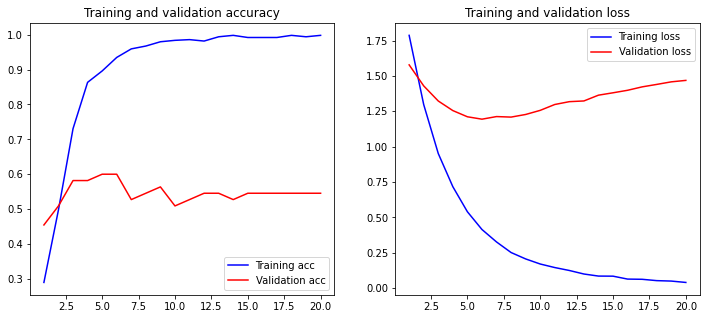

In [ ]:
plot_history(history)

#abstract

In [ ]:
from sklearn.model_selection import train_test_split 
Yabs = np.array(yabs)
Xabs_train, Xabs_test, yabs_train, yabs_test = train_test_split(abstract, Yabs, test_size=0.2)

In [ ]:
tokenize.fit_on_texts(Xabs_train) # fit tokenizer to our training text data
xabs_train = tokenize.texts_to_matrix(Xabs_train, mode='tfidf')
xabs_test = tokenize.texts_to_matrix(Xabs_test, mode='tfidf')

In [ ]:
encoder = LabelEncoder()
encoder.fit(yabs_train)
yabs_train1 = encoder.transform(yabs_train)
yabs_test1 = encoder.transform(yabs_test)

In [ ]:
# Converts the labels to a one-hot representation
num_classes = np.max(yabs_train1) + 1
yabs_train = keras.utils.to_categorical(yabs_train1, num_classes)
yabs_test = keras.utils.to_categorical(yabs_test1, num_classes)

In [ ]:
batch_size = 32
epochs = 20
drop_ratio = 0.5

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(xabs_train, yabs_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
9/9 [==============================] - 1s 36ms/step - loss: 2.5028 - categorical_accuracy: 0.2152 - val_loss: 1.8705 - val_categorical_accuracy: 0.4194
Epoch 2/20
9/9 [==============================] - 0s 9ms/step - loss: 0.9050 - categorical_accuracy: 0.6842 - val_loss: 1.8182 - val_categorical_accuracy: 0.3871
Epoch 3/20
9/9 [==============================] - 0s 9ms/step - loss: 0.3316 - categorical_accuracy: 0.9007 - val_loss: 1.8767 - val_categorical_accuracy: 0.4194
Epoch 4/20
9/9 [==============================] - 0s 10ms/step - loss: 0.2363 - categorical_accuracy: 0.9236 - val_loss: 1.9243 - val_categorical_accuracy: 0.4194
Epoch 5/20
9/9 [==============================] - 0s 9ms/step - loss: 0.1341 - categorical_accuracy: 0.9793 - val_loss: 1.9139 - val_categorical_accuracy: 0.3871
Epoch 6/20
9/9 [==============================] - 0s 10ms/step - loss: 0.1206 - categorical_accuracy: 0.9834 - val_loss: 1.9748 - val_categorical_accuracy: 0.4194
Epoch 7/20
9/9 [=========

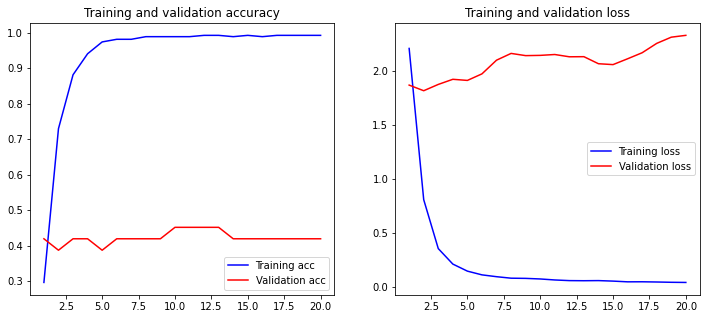

In [ ]:
plot_history(history)

In [ ]:
yhat_classes = model.predict_classes(xabs_test, verbose=0)
yhat_classes

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([2, 1, 1, 2, 6, 6, 1, 6, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 6, 2, 4, 4,
       2, 2, 2, 4, 2, 0, 2, 1, 4, 2, 6, 4, 6, 2, 0, 0, 2, 2, 6, 3, 2, 6,
       6, 6, 2, 6, 2, 2, 2, 3, 6, 2, 0, 2, 6, 2, 2, 2, 0, 4, 6, 2, 2, 4,
       2, 2, 2, 2, 2, 6, 2, 6, 2, 1])

In [ ]:
print(classification_report(yhat_classes, yabs_test1,target_names=Labels))

                 precision    recall  f1-score   support

    Pronostique       0.33      0.67      0.44         6
   Modélisation       0.67      0.80      0.73         5
  Thérapeutique       0.70      0.41      0.52        39
         Autres       0.20      0.33      0.25         3
Epidémiologique       0.21      0.43      0.29         7
   Diagnostique       0.00      0.00      0.00         0
Recommandations       0.87      0.81      0.84        16

       accuracy                           0.54        76
      macro avg       0.43      0.49      0.44        76
   weighted avg       0.64      0.54      0.56        76



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
